In [47]:
# Import Packages
import pandas as pd
import unidecode
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import gc
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
from collections import defaultdict
import statistics
from rouge import Rouge

# if uising a Jupyter notebook, include:
%matplotlib inline

# Hide warnings
warnings.filterwarnings('ignore')

### Data Ingest

In [48]:
# Load data files
community_df = pd.read_csv("data/community.csv")
news_df = pd.read_csv("data/news.csv")
multilingual_df = pd.read_csv("data/multilingual.csv")

In [49]:
# Test loaded files
community_df.head(3)

,question_id,title,question,answer_id,answer,answer_type,wrong_answer,wrong_answer_type,url,source
0,14057,Can pets catch the cold?,Last night I was drying my cat with a towel af...,14083,Yes they can. The viruses that cause a cold in...,Accepted,"That is a Priapulid worm, also known as a ""pen...",Random,biology.stackexchange.com,biomedical
1,89709,Is the Common Cold an Immune Overreaction?,It's my understanding that the majority of sym...,89712,Can someone die of the common cold?\n\nNo. \nT...,Accepted,"The dash (""-"") does not represent a negative c...",Random,biology.stackexchange.com,biomedical
2,89886,Air purifier agains bacteria and viruses?,We would buy a mobile air purifier in our home...,89887,The aforementioned filter will filter microbes...,Accepted,"It's a bleu ray gelyfish, don't tauch is becau...",Random,biology.stackexchange.com,biomedical


In [50]:
news_df.head(3)

,source,url,question,answer,wrong_answer
0,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,What are the symptoms?,"Symptoms include fever, coughing, sore throat,...","As cases of coronavirus surge, health authorit..."
1,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,When should I get tested?,Your doctor will tell you if you need to get t...,If you have been in contact with a person with...
2,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,What's the difference between physical distanc...,"As cases of coronavirus surge, health authorit...","Remember, the vast majority of Australians are..."


In [51]:
multilingual_df.head(3)

,question,answer,url,language,source,section,wrong_answer
0,什么是新型冠状病毒？,新型冠状病毒是一种此前尚未确定的新冠状病毒。导致新型冠状病毒肺炎 | 新冠肺炎2019（CO...,https://chinese.cdc.gov/coronavirus/2019-ncov/...,chinese,CDC,Frequently Asked Questions,使用 CDC 开发的诊断检测，结果为阴性是指在受测者样本中未发现导致 COVID-19 的病...
1,为什么这种疾病被称为 2019 年新型冠状病毒肺炎（COVID-19）？,2020 年 2 月 11 日，世界卫生组织宣布了导致最初于中国武汉发现的 2019 年新型...,https://chinese.cdc.gov/coronavirus/2019-ncov/...,chinese,CDC,Frequently Asked Questions,引发COVID-19的病毒被认为主要以人传人的方式，通过感染患者咳嗽或打喷嚏时产生的呼吸道飞...
2,为什么有人会因为 COVID-19 而指责或躲避某些个人和群体（制造污名）？,美国民众可能对住在或前往COVID-19传播地区的亲友感到担心焦虑。有些人很担心通过这些人感...,https://chinese.cdc.gov/coronavirus/2019-ncov/...,chinese,CDC,Frequently Asked Questions,目前，没有证据表明COVID-19病毒会从宠物的皮肤或皮毛传播给人类。\n关于照顾宠物的最佳...


In [52]:
### In what languages are the text written in multilingual dataframe 
multilingual_df['language'].unique()

array(['chinese', 'english', 'korean', 'spanish', 'vietnamese', 'arabic',
       'french', 'russian'], dtype=object)

In [53]:
### We are only interested in english language data
multilingual_df = multilingual_df[multilingual_df['language']=='english']

In [54]:
multilingual_df.head(3)

,question,answer,url,language,source,section,wrong_answer
77,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...,https://www.cdc.gov/coronavirus/2019-ncov/faq....,english,CDC,Frequently Asked Questions,"Using the CDC-developed diagnostic test, a neg..."
78,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza...",https://www.cdc.gov/coronavirus/2019-ncov/faq....,english,CDC,Frequently Asked Questions,The virus that causes COVID-19 is thought to s...
79,Why might someone blame or avoid individuals a...,People in the U.S. may be worried or anxious a...,https://www.cdc.gov/coronavirus/2019-ncov/faq....,english,CDC,Frequently Asked Questions,"At this time, there is no evidence that the vi..."


In [55]:
### Combining the common columns of the 3 dataframes
combined_df = pd.concat([news_df,multilingual_df,community_df],ignore_index=False, join="inner")
combined_df

,source,url,question,answer,wrong_answer
0,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,What are the symptoms?,"Symptoms include fever, coughing, sore throat,...","As cases of coronavirus surge, health authorit..."
1,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,When should I get tested?,Your doctor will tell you if you need to get t...,If you have been in contact with a person with...
2,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,What's the difference between physical distanc...,"As cases of coronavirus surge, health authorit...","Remember, the vast majority of Australians are..."
3,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,How do I practice physical distancing?,If you have been in contact with a person with...,Other countries have closed schools and univer...
4,ABC Australia,https://www.abc.net.au/triplej/programs/hack/c...,What's closed?,Physical distancing is the reason the Federal ...,"Symptoms include fever, coughing, sore throat,..."
...,...,...,...,...,...
637,general,travel.stackexchange.com,I read on https://twitter.com/RichardBarrow/st...,The additional check in time is needed for all...,The visa requirements state that an applicant ...
638,general,travel.stackexchange.com,I am a refugee in South Africa with a refugee ...,Online applications for Canadian visas start h...,"You will need a transit visa, as all visas and..."
639,general,travel.stackexchange.com,I had a ski trip planned from 14th March - 21s...,The wording states \n\n\n...or similar body re...,I got mugged when living in France. The phrase...
640,general,travel.stackexchange.com,I have booked a ticket for future travel but n...,You can't just 'cancel because of coronavirus'...,A couple of points \n1 - unlike in France and ...


In [56]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 641
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source        1295 non-null   object
 1   url           1297 non-null   object
 2   question      1297 non-null   object
 3   answer        1293 non-null   object
 4   wrong_answer  1293 non-null   object
dtypes: object(5)
memory usage: 60.8+ KB


In [57]:
# How many columns have null value
combined_df.isnull().any()

source           True
url             False
question        False
answer           True
wrong_answer     True
dtype: bool

In [58]:
# How many records have missing answers
combined_df[combined_df['answer'].isnull()==True]

,source,url,question,answer,wrong_answer
78,CNN,https://www.cnn.com/2020/03/25/politics/corona...,How and when do I get my check?,NaN,NaN
79,NaN,President Donald Trump and Treasury Secretary ...,Most viruses don’t spread easily on airplanes ...,NaN,NaN
431,USA Today,https://www.usatoday.com/story/news/health/202...,What are dangers to pregnant women?,NaN,NaN
432,NaN,It's unclear how the coronavirus may affect pr...,"No, Hotez says. As far as we know, it's not a ...",NaN,NaN


In [59]:
# Dropping rows with missing answers
combined_df.dropna(subset=['answer'],inplace=True)

### EDA

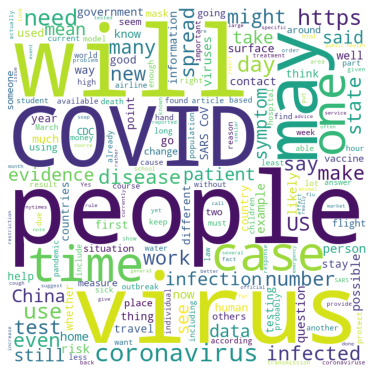

In [60]:
# plot the WordCloud image  
all_words = '' 

#looping through all answers and joining them to one text, to extract most common words
for arg in combined_df["answer"]: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words)                       
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Text- Preprocessing

In [61]:
# Getting an idea of the structure of the text inorder to decide the required preprocessing
combined_df['answer'].unique()

array(["Symptoms include fever, coughing, sore throat, fatigue, and shortness of breath.\nHowever, be aware that at this stage if you have a cough or a cold, it's likely that you just have a cough or a cold and not coronavirus.\nIf you have serious symptoms such as difficulty breathing, call 000 for urgent medical help.\nIf you get these symptoms above after being in contact with someone who has been diagnosed with COVID-19, seek medical attention.\nThe same goes if you develop symptoms within 14 days of returning home to Australia after being overseas.",
       'Your doctor will tell you if you need to get tested.',
       "As cases of coronavirus surge, health authorities are advising Australians to practise physical distancing (also called social distancing) as much as possible to limit transmission. Physical distancing is what everyone can do - like staying home - regardless of whether or not they've been exposed to coronavirus.\nSelf-isolating or self-quarantining is a more strict

#### The text has many "\n" , quotations and http links that can be removed. Contractions can be expanded.  

Remove accented characters from text, e.g. café

In [62]:
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
combined_df['prep_answer']=combined_df['answer'].apply(lambda x:remove_accented_chars(x))

Lowercase the text. In NLP, models treat words like Goat and goat differently, even if they are the same. Therefore, to overcome this problem, I am using the lower() function available in Python for converting text to lowercase

In [63]:
combined_df['prep_answer'] = combined_df['prep_answer'].apply(lambda x: x.lower())

Expand shortened words, e.g. "don't" to "do not"

In [64]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

combined_df['prep_answer'] = combined_df['prep_answer'].apply(lambda x: decontracted(x))

Removing new line character '\n'and quotation from the text. Removing all punctuations except .,-:/

In [65]:
def preprocess(ReviewText):
    ReviewText = re.sub(' +', ' ', ReviewText) #Stripping extra whitespace
    ReviewText = ReviewText.replace('https', 'http') # Replace https with http
    ReviewText= re.sub( '[^a-zA-Z0-9.,-:/]', ' ', ReviewText)
    return ReviewText

Punctuation would aid us to extrapolate next words given previous word(s). For instance, in the sentence: “Symptoms include fever, coughing, sore throat, fatigue, and shortness of breath”, use of commas provide information that there are additional symptoms. Thus, we did not remove all the punctuations.

Moreover, since our goal is to generate the next word given an input word(s), stemming and lemmatization would not be relevant in our case.

In [66]:
combined_df['prep_answer'] = combined_df['prep_answer'].apply(lambda x:preprocess(x))

In [67]:
#Vewing the pre-processed data
combined_df['prep_answer'].unique()

array(['symptoms include fever, coughing, sore throat, fatigue, and shortness of breath. however, be aware that at this stage if you have a cough or a cold, it is likely that you just have a cough or a cold and not coronavirus. if you have serious symptoms such as difficulty breathing, call 000 for urgent medical help. if you get these symptoms above after being in contact with someone who has been diagnosed with covid-19, seek medical attention. the same goes if you develop symptoms within 14 days of returning home to australia after being overseas.',
       'your doctor will tell you if you need to get tested.',
       'as cases of coronavirus surge, health authorities are advising australians to practise physical distancing  also called social distancing  as much as possible to limit transmission. physical distancing is what everyone can do - like staying home - regardless of whether or not they have been exposed to coronavirus. self-isolating or self-quarantining is a more strict a

### Sentence Tokenization

In [68]:
def sentence_tokenizer(text):
    sentences = nltk.sent_tokenize(text) # NLTK function
    return sentences

In [69]:
sentence_tokens = combined_df.prep_answer.map(sentence_tokenizer).sum()

In [70]:
#sentence_tokens

In [71]:
#Total Number of sentences 
len(sentence_tokens)

11531

20 Most common sentences

In [72]:
counter= Counter(sentence_tokens)
counter.most_common(20)

[('no.', 23),
 ('yes.', 17),
 ('source.', 9),
 ('more...', 8),
 ('.', 8),
 ('e.g.', 7),
 ('this means covering your mouth and nose with your bent elbow or tissue when you cough or sneeze.',
  5),
 ('the c.d.c.', 5),
 ('once contaminated, hands can transfer the virus to your eyes, nose or mouth.',
  4),
 ('if you have a fever, cough and difficulty breathing, seek medical attention and call in advance.',
  4),
 ('calling in advance will allow your health care provider to quickly direct you to the right health facility.',
  4),
 ('not yet.', 4),
 ('probably not.', 4),
 ('wash your hands often with soap and water for at least 20 seconds, especially after blowing your nose, coughing, or sneezing  going to the bathroom  and before eating or preparing food.',
  4),
 ('if soap and water are not readily available, use an alcohol-based hand sanitizer with at least 60  alcohol.',
  4),
 ('many countries around the world have seen cases of covid-19 and several have seen outbreaks.',
  3),
 ('autho

### Word Tokenization

In [73]:
def word_tokenizer(text):
    return nltk.tokenize.regexp.WordPunctTokenizer().tokenize(text)

In [74]:
word_tokens = combined_df.prep_answer.map(word_tokenizer).sum()

In [75]:
# Total Number of words/tokens
len(word_tokens)

310246

In [76]:
# Average length of sentences
print("Average length:", round(len(word_tokens)/len(sentence_tokens)), "words per sentence")

Average length: 27 words per sentence


In [77]:
#Word Tokens
print(word_tokens[:200])

['symptoms', 'include', 'fever', ',', 'coughing', ',', 'sore', 'throat', ',', 'fatigue', ',', 'and', 'shortness', 'of', 'breath', '.', 'however', ',', 'be', 'aware', 'that', 'at', 'this', 'stage', 'if', 'you', 'have', 'a', 'cough', 'or', 'a', 'cold', ',', 'it', 'is', 'likely', 'that', 'you', 'just', 'have', 'a', 'cough', 'or', 'a', 'cold', 'and', 'not', 'coronavirus', '.', 'if', 'you', 'have', 'serious', 'symptoms', 'such', 'as', 'difficulty', 'breathing', ',', 'call', '000', 'for', 'urgent', 'medical', 'help', '.', 'if', 'you', 'get', 'these', 'symptoms', 'above', 'after', 'being', 'in', 'contact', 'with', 'someone', 'who', 'has', 'been', 'diagnosed', 'with', 'covid', '-', '19', ',', 'seek', 'medical', 'attention', '.', 'the', 'same', 'goes', 'if', 'you', 'develop', 'symptoms', 'within', '14', 'days', 'of', 'returning', 'home', 'to', 'australia', 'after', 'being', 'overseas', '.', 'your', 'doctor', 'will', 'tell', 'you', 'if', 'you', 'need', 'to', 'get', 'tested', '.', 'as', 'cases', 

In [78]:
most_common=([t[0] for t in Counter(word_tokens).most_common(200)])

In [79]:
# Top 200 words
print(most_common)

['.', 'the', ',', 'to', 'of', 'and', '-', 'a', 'is', 'in', 'that', 'for', 'you', 'not', 'are', 'it', '/', 'be', 'or', 'with', 'have', 'on', 'this', 'as', 'if', 'can', ':', 'your', 'from', 'at', 'but', 'they', 'will', 'i', 'by', 'people', '19', 'there', 'virus', 'covid', 'an', 'do', 'who', 'more', 'would', 'coronavirus', 'has', 'so', 'which', 'we', 'some', 'health', 'their', 'other', 'also', '1', 'was', 'may', 'no', 'all', 'about', 'should', 'one', '2', 'been', 'than', 'time', 'when', 'get', 'what', 'http', '://', 'could', 'infected', 'out', 'like', 'any', 'up', 'how', 'only', 'these', 'does', 'cases', 'then', 'disease', 'most', '0', 'such', 'new', 'use', 'them', 'need', 'those', 'after', 'because', 'risk', 'were', 'us', 'www', 'many', 'sars', '2020', 'said', 'even', 'symptoms', 'days', 'spread', 'person', 'china', 'home', 'might', 'make', 'still', 'travel', 'just', 'case', 'very', 'where', 'evidence', 'number', 'test', 'viruses', 'however', 'now', 'data', 'care', 'into', 'while', 'work

Word Cloud for Top 200 words

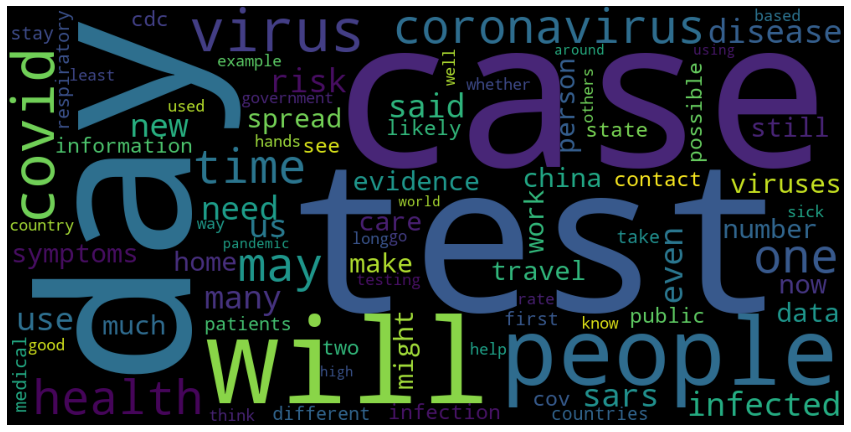

In [80]:
# plot the WordCloud image  
unique_string=(" ").join(most_common)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

Frequency Distribution of the Top 50 words

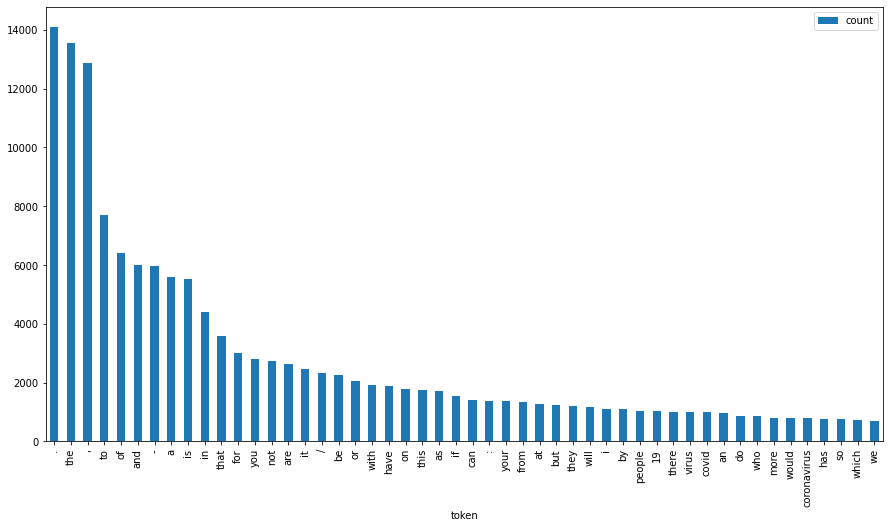

In [81]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(Counter(word_tokens).most_common(50),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token', figsize=(15,8));

In [82]:
# Freq of words
freqDist = nltk.FreqDist(word_tokens)
print(freqDist)
unique_words = freqDist.keys()
print("Total Number of unique words is:", len(unique_words))

<FreqDist with 15838 samples and 310246 outcomes>
Total Number of unique words is: 15838


Since we are interested in generating a complete correct answer column, we are padding each answer as opposed to words/characters/sentence.

In [83]:
# Add padding to sentences
#combined_df['prep_answer'] = combined_df['prep_answer'].apply(lambda x: '<s>' + x + '</s>')

In [84]:
#Final Pre-processed answers
combined_df['prep_answer'].unique()

array(['symptoms include fever, coughing, sore throat, fatigue, and shortness of breath. however, be aware that at this stage if you have a cough or a cold, it is likely that you just have a cough or a cold and not coronavirus. if you have serious symptoms such as difficulty breathing, call 000 for urgent medical help. if you get these symptoms above after being in contact with someone who has been diagnosed with covid-19, seek medical attention. the same goes if you develop symptoms within 14 days of returning home to australia after being overseas.',
       'your doctor will tell you if you need to get tested.',
       'as cases of coronavirus surge, health authorities are advising australians to practise physical distancing  also called social distancing  as much as possible to limit transmission. physical distancing is what everyone can do - like staying home - regardless of whether or not they have been exposed to coronavirus. self-isolating or self-quarantining is a more strict a

In [85]:
### Removing redundant variables
del community_df
del multilingual_df
del news_df
del all_words
del arg
del sentence_tokens
del freq_df
del most_common
del counter
del tokens
del unique_string
del wordcloud
del freqDist

# Garbage collection
print(gc.get_count())  # Before gc
gc.collect()
print(gc.get_count())  # After gc

(334, 0, 1)
(34, 0, 0)


In [86]:
### Baseline model development and testing

In [87]:
# Split into train and test sets
random.seed(5)
X_train, X_test = train_test_split(combined_df, test_size=0.2)

In [88]:
# Vectorize training set questions
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.question)
X_train_tfidf.shape

(1034, 8395)

Compute clusters

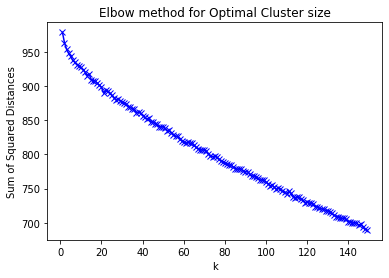

In [43]:
# Optimal cluster size using Elbow method
squared_distances = []
K = range(1, 150)
for k in K:
    km = KMeans(k)
    km = km.fit(X_train_tfidf)
    squared_distances.append(km.inertia_)

plt.plot(K , squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow method for Optimal Cluster size')
plt.show()


Since gradient of the within-cluster sum of squares distance is similar even at high cluster sizes, we go with a larger cluster size of 150.

In [89]:
# Compute clusters
cluster_size = 150
model_kmeans = KMeans(cluster_size)
model_kmeans.fit(X_train_tfidf)

KMeans(n_clusters=150)

In [90]:
# Add cluster data to train set
X_train.loc[:, 'cluster'] = model_kmeans.labels_

# Convert prep_answer to 5-gram tokens
X_train['prep_answer2'] = X_train['prep_answer'].apply(lambda x: list(nltk.ngrams(nltk.lm.preprocessing.pad_both_ends(word_tokenizer(x), n=5), n=5)))

# Add start and stop tokens to vocabulary
unique_words = list(unique_words)
unique_words.append('<s>')
unique_words.append('</s>')

Laplace Generation

In [91]:
# Laplace smoothing
eng_laplace = dict()
for i in range(cluster_size):
    eng_laplace[i] = nltk.lm.Laplace(5, vocabulary = nltk.lm.Vocabulary(unique_words))
    eng_laplace[i].fit(X_train.loc[X_train['cluster'] == i, 'prep_answer2'])

In [113]:
# Generate text using start word and cluster number
def laplace_generation_fivegram(start_word, cluster):
    sentence = start_word
    word = start_word
    prev_word1 = '<s>'
    prev_word2 = '<s>'
    prev_word3 = '<s>'

    # Check if word != </s>
    while word != '</s>':
        trans_word = word
        word = eng_laplace[cluster].generate(text_seed=[prev_word3, prev_word2, prev_word1, word])
        if word.isalnum():
            sentence += ' '     # Add spacing between words
        sentence += word
        prev_word3 = prev_word2
        prev_word2 = prev_word1
        prev_word1 = trans_word

    # Remove start and stop tokens
    sentence = sentence.replace('<s>', '')
    sentence = sentence.replace('</s>', '')
    return sentence

# Test
laplace_generation_fivegram('<s>', 1)

' right now, as covid- 19 is on- going, they can not do very much to prepare for a hypothetical covid-. however, once the covid- 19 situation has ended, then it would be vital to do a thorough analysis of what worked, and did not work in the covid- 19 situation has ended, then it would be vital to do a thorough analysis of what worked, and did not work in the covid- 19 situation has ended, then it would be vital to do a thorough analysis of what worked, and did not work in the covid- 19 situation. this is one of the reasons, why the east- asian countries, such as hong kong or korea have fared so well compared to europe they could build on first hand experience of the sars and mers outbreaks. the somewhat sad lesson is that we are smarter only afterwards. any attempts to predict the future, and act accordingly to these predictions is bound to fail at least in part of the cases. you find plenty of articles in the media, comparing the current, local situation to those in the east asian co

In [114]:
# Testing with test set
X_test_tfidf = tfidf_vectorizer.transform(X_test.question)

predicted = []
clusters = []
for cluster in model_kmeans.predict(X_test_tfidf):
    clusters.append(cluster)
    predicted.append(laplace_generation_fivegram('<s>', cluster))   # Predicting answer text using first word and cluster number

X_test['cluster'] = clusters

In [115]:
# View results
results = pd.DataFrame(data = {'Question': X_test.question, 'Predicted Answer': predicted})
results.head(10)

,Question,Predicted Answer
127,"As the German chancellor said today, by the en...","at least in italy, this appears to be in part..."
190,How long does the virus survive on surfaces?,diluted household bleach solutions can be use...
631,Someone I know booked a return flight on Air S...,"in general, you are not freed of contractual ..."
211,"Apparently, a new coronavirus related paid fam...","looking on the fda website, i found this: not..."
120,There's a ridiculous conspiracy theory spreadi...,scientists advising the government told them ...
2,What's the difference between physical distanc...,you might wonder whether an increased infecti...
330,UK government promises to pay 80% of wages for...,"tl dr: you can, possibly, in some places, but..."
586,I want to remove or replace my implant or IUD ...,"all pregnant women, including those with conf..."
457,Are there any projections to estimate the spre...,there are some theories that the covid- 19 ou...
350,I used to travel a lot and take photographs at...,people are laid off all the time when sales a...


In [116]:
# Write to external file
X_train.to_csv("output/x_train.csv")
X_test.to_csv("output/x_test.csv")

In [117]:
# Testing with custom test set
docs_new = ['What is coronavirus?',
            'What are symptoms of COVID',
            'What is COVID?',
            'I have a cough. Do I have corona?',
            'Does my friend have COVID?',
            'How many people in USA have COVID?',
            'How many people in the world have covid19?']
X_test_tfidf = tfidf_vectorizer.transform(docs_new)

predicted_custom = []
for cluster in model_kmeans.predict(X_test_tfidf):
    predicted_custom.append(laplace_generation_fivegram('<s>', cluster))

In [119]:
# View results
results_custom = pd.DataFrame(data = {'Question': docs_new, 'Predicted Answer': predicted_custom})
results_custom

,Question,Predicted Answer
0,What is coronavirus?,coronavirus is a type of virus that causes di...
1,What are symptoms of COVID,"symptoms include fever, coughing, sore throat..."
2,What is COVID?,coronaviruses are a large family of viruses w...
3,I have a cough. Do I have corona?,welfare bodies want a ban on housing eviction...
4,Does my friend have COVID?,there is no limit. even if you try to return ...
5,How many people in USA have COVID?,"of course, eating too much or too little in t..."
6,How many people in the world have covid19?,"more than 191, 000 people worldwide have reco..."


In [120]:
# Build answer dictionaries
answer = defaultdict(list)
answer_rogue = defaultdict(list)
reference = []
for i in range(len(X_test)):
    cluster = X_test['cluster'].iloc[i]
    if answer[cluster] is None:
        answer[cluster] = []
        answer_rogue[cluster] = []
    answer[cluster].append(word_tokenizer(X_test['prep_answer'].iloc[i]))
    answer_rogue[cluster].append(X_test['prep_answer'].iloc[i])

In [121]:
# Compute bleu score
bleu_score = []
for i in range(len(X_test)):
	cluster = X_test.cluster.iloc[i]
	test = list(answer[cluster])
	predicted_test = predicted[i].split(' ')
	bleu_score.append(nltk.translate.bleu_score.sentence_bleu(test, predicted_test))

In [122]:
## Compute bleu scores
# Mean
statistics.mean(bleu_score)

0.05755938174869327

In [123]:
# Max
max(bleu_score)

0.7954658179355575

In [124]:
# Min
min(bleu_score)

5.8942399846822315e-238

In [125]:
# Compute rogue scores
references = list(X_test.prep_answer)
candidates = list(predicted)

rouge = Rouge()
scores = rouge.get_scores(candidates, references, avg=True)
scores

{'rouge-1': {'f': 0.1850382143980261,
  'p': 0.23880430890235596,
  'r': 0.24589599278523083},
 'rouge-2': {'f': 0.03519964989094456,
  'p': 0.04415395631787685,
  'r': 0.041722112423927454},
 'rouge-l': {'f': 0.1608940067964608,
  'p': 0.19339800478750366,
  'r': 0.19546875196377592}}